# Analysis for Multi Parameter Simulation
***

This notebook shows how to analyze the results of simulation runs with multiple parameters.


## 1) Obtain directories and parameter ranges

First, we import relevant libraries:

In [1]:
import numpy as np
import os
import networkx as nx
import pickle

Set the parameter to be analyzed:

In [2]:
var_key = "anisotropy";

Set the directories, and obtain the number of values and simulation runs:

In [3]:
home = os.getcwd();
simdir = "Examples/Osteocytes";
subdir = os.path.join(home,simdir,var_key);
rundir = [os.path.join(subdir,v) for v in os.listdir(subdir) if os.path.isdir(os.path.join(subdir,v)) and not v.startswith('.')];

num_val = len(rundir);

for r in rundir:
    w = [os.path.join(r,run) for run in os.listdir(r) if os.path.isdir(os.path.join(r,run)) and not run.startswith('.')];
    num_runs = len(w);

Generate sorted numpy array with parameters:

In [4]:
# replace int() by float() depending on type of parameter
var_range = [float(v) for v in os.listdir(subdir) if os.path.isdir(os.path.join(subdir,v)) and not v.startswith('.')];

var_range.sort()

print("Values for "+var_key+": "+str(var_range))

Values for anisotropy: [0.0, 0.25, 0.5, 0.75, 1.0]


## 2) Functions to return different properties for given directory and run:


Define a dictionary with the names of the properties we will obtain:

In [5]:
prop_list = ("Number of Nodes",
              "Average Degree",
              "Average Clustering Coefficient",
              "Average Shortest Path Length",
              "Edge Density",
              "Betweenness Centrality",
              "Information Centrality",
              "Harmonic Centrality",
              "Connected Components"
             )

Define another dictionary with the symbols of the properties, for the y-axis:

In [6]:
prop_str = ("N",
              "<k>",
              "<cc>",
              "ASP",
              "Edge Density",
              "<C$_B$>",
              "<C$_I$>",
              "<C$_I$>",
              "N$_c$"
             )

Define a function to calculate the different properties for a given networkx graph "G":

In [7]:
def get_props(G):

    prop = np.zeros(len(prop_list))

    prop[8] = nx.number_connected_components(G);
    largest_cc = max(nx.connected_components(G), key=len)
    Gc = G.subgraph(largest_cc).copy()

    prop[0]=Gc.number_of_nodes()   
    G_deg = nx.degree_histogram(Gc)
    n=0;
    G_deg = G_deg[n:10]
    G_deg_sum = [a * b for a, b in zip(G_deg, range(n, len(G_deg)+n))]
    prop[1]=sum(G_deg_sum)/sum(G_deg)
    prop[2]=nx.average_clustering(Gc)    
    prop[3]=nx.average_shortest_path_length(Gc,weight="weight");
    prop[4]=nx.density(Gc)   
    prop[5]=np.mean(np.array(list(nx.betweenness_centrality(Gc,k=100).values())))
    prop[6]=np.mean(np.array(list(nx.information_centrality(Gc).values())))
    prop[7]=np.mean(np.array(list(nx.harmonic_centrality(Gc).values())))
    return prop
    

## 3) Compute graph properties parallel

Since the calculations take quite some time, we run it in parallel for all runs using the multiprocessing module:

In [8]:
from multiprocessing import Pool

Before starting, we initialize an empty array that will take all the different property values:

In [9]:
num_prop = len(prop_list)

p = np.zeros((num_val,num_prop,num_runs))

Create a dictionary of paths and iterate over all parameter values to obtain the properties for all runs:

In [10]:
rdir = [os.path.join(subdir,str(r)) for j,r in enumerate(var_range)]

In [ ]:
for j in range(num_val):

    def get_prop(i):
        with open(os.path.join(rdir[j],str(i),'G.pkl'), 'rb') as f:
            G = nx.read_gpickle(f)
        return get_props(G)

    pool = Pool(processes=num_runs)
    result = pool.map(get_prop,range(num_runs));
    pool.close()
    pool.join()
    
    for i,res in enumerate(result):
        p[j,:,i] = res;
    

Save the obtained property array:

In [ ]:
with open(os.path.join(subdir,'p.pkl'), 'wb') as f:
    pickle.dump(p, f)
   

Alternatively, instead of running the calculation above, load a previously saved parameter file:

In [11]:
with open(os.path.join(subdir,'p.pkl'), 'rb') as f:
    p = pickle.load(f)

## 4) Create parameter plots

We define a plot function:

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_prop(var_range,param,var_name,prop_name,prop_str):

    fig = plt.figure(figsize=(4,3.5))
    ax = plt.axes()
    ax.scatter(np.repeat(var_range,num_runs), param,color='k', alpha=0.15, s=80)
    ax.scatter(var_range,np.mean(param,axis=1),color='r',s=150)

    ax.set_xlabel(var_name, fontsize=15)
    ax.set_ylabel(prop_str, fontsize=15)
    ax.set_title(prop_name, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=10)
    fig.tight_layout()
    plt.show()
    


Now you can plot any of the properties against the range of parameters, averaged over all runs, for example, the second property (average clustering coefficient):

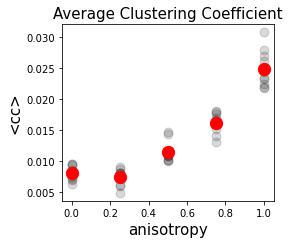

In [14]:
i = 2;

plot_prop(var_range[:],p[:,i,:],var_key,prop_list[i],prop_str[i])


***
## 5) Generate Mayavi visualization and connectivity graph

Regenerate cell coordinates for Osteocyte Network scenario:

In [15]:
cells = np.array([[128,64,128],[128,128,128],[128,192,128],
                  [64,96,128], [64,160,128],
                  [192,96,128],[192,160,128],
                  [128,96,96], [128,160,96],
                  [64,64,96],  [64,128,96],  [64,192,96],
                  [192,64,96], [192,128,96], [192,192,96],
                  [128,96,160],[128,160,160],
                  [64,64,160], [64,128,160], [64,192,160],
                  [192,64,160],[192,128,160],[192,192,160]]);

N_cells = cells.shape[0]

w = 7
l = 12
h = 4

Import Mayavi (requires 3D accelerated X-Server or VirtualGL):

In [16]:
from mayavi import mlab
mlab.init_notebook(backend="png")

Notebook initialized with png backend.


Generate Mayavi visualization of a specific run for a specific parameter value:


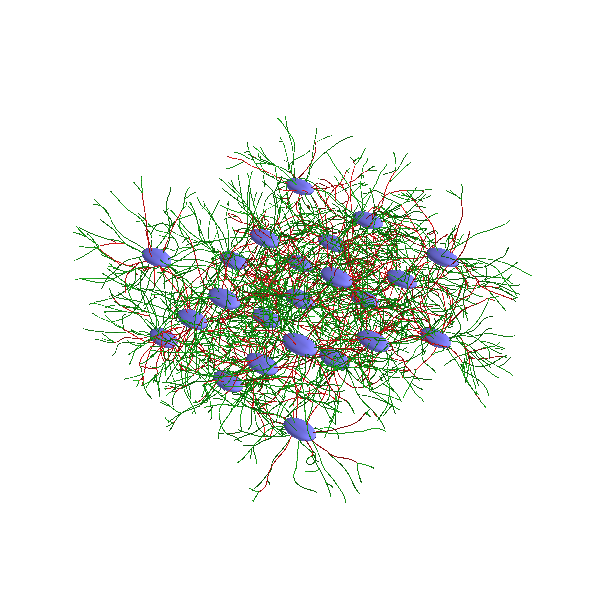

In [17]:
value=0;
run=0;

d=os.path.join(rdir[value],str(run))

with open(os.path.join(d,'cod.pkl'), 'rb') as f:
        cod = pickle.load(f)
    
fig = mlab.figure(bgcolor=(1,1,1),size=(600,600))
    
for i in cells:
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = w * np.outer(np.cos(u), np.sin(v)) + i[0]
    y = l * np.outer(np.sin(u), np.sin(v)) + i[1]
    z = h * np.outer(np.ones(np.size(u)), np.cos(v)) + i[2]
    cu = mlab.mesh(x, y, z, color=(0.5,0.5,1.0))
        
for key in cod: 
    if cod[key].pos_list.shape[0] > 3:
        cod[key].spline_fitq(s=2)  
        x = cod[key].new_pointsq[0];
        y = cod[key].new_pointsq[1];
        z = cod[key].new_pointsq[2];
    else:
        x = cod[key].pos_list[:,0];
        y = cod[key].pos_list[:,1];
        z = cod[key].pos_list[:,2];

    if cod[key].sleep_merge_event == [('growing')]:
        color = (0.1,0.6,0.1);
    else:
        color = (0.8,0.1,0.1); 
            
    mlab.plot3d(x,y,z, color = color, line_width=1.0, tube_radius=0.3)
    
cu

Plot connectivity graph for the same run using networkx:

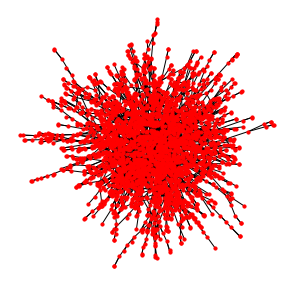

In [18]:
with open(os.path.join(d,'G.pkl'), 'rb') as f:
        G = pickle.load(f)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

nx.draw_spring(G,with_labels = False,node_size = 10, node_color =  'r', node_shape = 'o')
